# Fine-tuning SpeechT5 for multilingual TTS

This notebook demonstrates how to fine-tune the SpeechT5 model from 🤗 Transformers on the **text-to-speech** task.

The unique thing about SpeechT5 is that the model is first pre-trained on a combination of speech-to-text and text-to-speech data, so that it learns a unified space of hidden representations shared by both text and speech. This allows us to fine-tune the same pretrained model on different tasks. Read more about SpeechT5 [in our blog post](https://huggingface.co/blog/speecht5).

In this notebook we will start from an existing fine-tuned TTS model that was originally trained on English speech from LibriTTS, and fine-tune it for the Dutch language using the VoxPopuli dataset.

This TTS model will support multiple speakers through x-vector speaker embeddings.

## Install required packages

We install Transformers from GitHub since not all the SpeechT5 features we need have been merged into an official release yet.


In [68]:
!pip install -q datasets soundfile speechbrain

In [3]:
!pip install -q transformers

In [6]:
!pip install -q --upgrade accelerate

In [12]:
!pip install -q pyewts

In [21]:
import multiprocessing
from pathlib import Path
from collections import Counter

import pyewts
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import DatasetDict, Audio, concatenate_datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio as display_audio

In [22]:
sanity_check = False

n_cpu = multiprocessing.cpu_count() - 10; n_cpu
data_path = Path.cwd() / "data"
audio_path = data_path / "audio"
audio_path.mkdir(parents=True, exist_ok=True)

## Load model

In [23]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

## Load Dataset

In [24]:
converter = pyewts.pyewts()
print(converter.toUnicode('''to/zhesapa'o//[ ╚]dkyus[╗'''))

ཏོ།ཞེསཔའོ༎ ╚དཀྱུས╗


In [25]:
dataset_path = data_path / "tts-training-processed"
dataset = DatasetDict.load_from_disk(dataset_path)
dataset

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 30000
    })
})

In [26]:
if sanity_check:
    dataset["train"] = dataset["train"].select(range(100))
    dataset["test"] = dataset["test"].select(range(20))

In [52]:
dataset = dataset.filter(lambda x: x["path"] and x["path"] != "None", num_proc=n_cpu)

Filter (num_proc=54):   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter (num_proc=54):   0%|          | 0/30000 [00:00<?, ? examples/s]

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [53]:
dataset['train'] = dataset['train'].cast_column("path", Audio(sampling_rate=16000))
dataset['test'] = dataset['test'].cast_column("path", Audio(sampling_rate=16000))

Let's quickly check how many examples are in this dataset.

In [54]:
dataset['train'][0]

{'uni': 'ང་ཚོའི་སྤུན་གྲོགས་གོ་ཏ་མ་སླེབས་སོང་།',
 'sentence': "nga tsho'i spun grogs go ta ma slebs song /",
 'label': 'STT_AB',
 'speaker_id': 'eeced487-f03a-494e-8814-eeabeb81263f',
 'duration': 1.707,
 'tokens_len': 44,
 'path': {'path': '/root/speech_t5_tts/data/audio/STT_AB00209_0153_576868_to_578575.wav',
  'array': array([-0.00192261, -0.00457764, -0.00639343, ...,  0.01286316,
          0.0098114 ,  0.00790405]),
  'sampling_rate': 16000}}

That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

In [55]:
def to_wylie(example):
    example["sentence"] = converter.toWylie(example["uni"])
    return example

In [56]:
dataset = dataset.map(to_wylie, num_proc=n_cpu)

Map (num_proc=54):   0%|          | 0/119949 [00:00<?, ? examples/s]

Map (num_proc=54):   0%|          | 0/29980 [00:00<?, ? examples/s]

In [57]:
dataset['train'][0]

{'uni': 'ང་ཚོའི་སྤུན་གྲོགས་གོ་ཏ་མ་སླེབས་སོང་།',
 'sentence': "nga tsho'i spun grogs go ta ma slebs song /",
 'label': 'STT_AB',
 'speaker_id': 'eeced487-f03a-494e-8814-eeabeb81263f',
 'duration': 1.707,
 'tokens_len': 44,
 'path': {'path': '/root/speech_t5_tts/data/audio/STT_AB00209_0153_576868_to_578575.wav',
  'array': array([-0.00192261, -0.00457764, -0.00639343, ...,  0.01286316,
          0.0098114 ,  0.00790405]),
  'sampling_rate': 16000}}

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [58]:
tokenizer = processor.tokenizer
a = tokenizer.get_vocab().items()

In [59]:
def extract_all_chars(batch):
    all_text = " ".join(batch["sentence"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset['train'].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset['train'].column_names,
)
vocabs = dataset['test'].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset['test'].column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/119949 [00:00<?, ? examples/s]

Map:   0%|          | 0/29980 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [60]:
dataset_vocab-tokenizer_vocab


{' ', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\\', '_'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [61]:
replacements = [
    ('_', '_'),
    ('*', 'v'),
    ('`', ';'),
    ('~', ','),
    ('+', ','),
    ('\\', ';'),
    ('|', ';'),
    ('╚',''),
    ('╗',''),
    ('停', ''),
    ('抢', ''),
    ('•', ''), ('0', ''), ('1', ''), ('2', ''), ('3', ''), ('4', ''), ('5', ''), ('6', ''), ('7', ''), ('8', ''), ('9', '')  
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["sentence"] = inputs["sentence"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text, num_proc=n_cpu)

Map (num_proc=54):   0%|          | 0/119949 [00:00<?, ? examples/s]

Map (num_proc=54):   0%|          | 0/29980 [00:00<?, ? examples/s]

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [62]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device ="cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

/opt/conda/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [63]:
def prepare_dataset(batch):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio_batch = batch["path"]
    sentence_batch = batch["sentence"]
    audio_array_batch = [audio["array"] for audio in audio_batch]
    sampling_rate = audio_batch[0]["sampling_rate"]

    example = processor(
        text=sentence_batch,
        audio_target=audio_array_batch,
        sampling_rate=sampling_rate,
        return_attention_mask=False,
    )

    example["sentence"] = sentence_batch
    example["labels"] = [label for label in example["labels"]]
    example["path"] = audio_batch
    example["speaker"] = batch['speaker_id']
    example["uni"] = batch["uni"]
    example["speaker_embeddings"] = [create_speaker_embedding(array) for array in audio_array_batch]

    return example

Let's verify the processing is correct by looking at a single example:

In [64]:
processed_example = prepare_dataset(dataset['train'].select(range(5)))
processed_example["speaker_embeddings"][0].shape

(512,)

In [65]:
processed_example["labels"][0].shape

(107, 80)

In [66]:
processed_example["uni"]

['ང་ཚོའི་སྤུན་གྲོགས་གོ་ཏ་མ་སླེབས་སོང་།',
 'གོང་ས་མཆོག་གི་འབད་བརྩོན་དང་།',
 'རང་དོན་ལས་ལྷག་པའི་དོན་ལ་ཕྱག་བཞེས་གནང་མཁན་ཞིག་ཡིན་འདུག',
 'ཁྱིམ་མཚེས་ཚང་མས་འཛུམ་མུལ་མུལ་གྱིས་འཚམས་འདྲི་ཞུ་ཞིང་།',
 'མ་ཧཱ་མཱ་ཡ་གནང་བར་ཞུ་ཟེར་ནས་ནན་གྱིས་ཆོས་ཞུས་ཤིག་']

In [67]:
[converter.toWylie(text) for text in processed_example["uni"]]

["nga tsho'i spun grogs go ta ma slebs song /",
 "gong sa mchog gi 'bad brtson dang /",
 "rang don las lhag pa'i don la phyag bzhes gnang mkhan zhig yin 'dug",
 "khyim mtshes tshang mas 'dzum mul mul gyis 'tshams 'dri zhu zhing /",
 'ma hA mA ya gnang bar zhu zer nas nan gyis chos zhus shig ']

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [68]:
list(processed_example.keys())

['input_ids',
 'labels',
 'sentence',
 'path',
 'speaker',
 'uni',
 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [69]:
[tokenizer.decode(input_ids) for input_ids in processed_example["input_ids"]]

["nga tsho'i spun grogs go ta ma slebs song /</s>",
 "gong sa mchog gi 'bad brtson dang /</s>",
 "rang don las lhag pa'i don la phyag bzhes gnang mkhan zhig yin 'dug</s>",
 "khyim mtshes tshang mas 'dzum mul mul gyis 'tshams 'dri zhu zhing /</s>",
 'ma hA mA ya gnang bar zhu zer nas nan gyis chos zhus shig</s>']

Speaker embeddings should be a 512-element vector:

In [70]:
processed_example["speaker_embeddings"][0].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

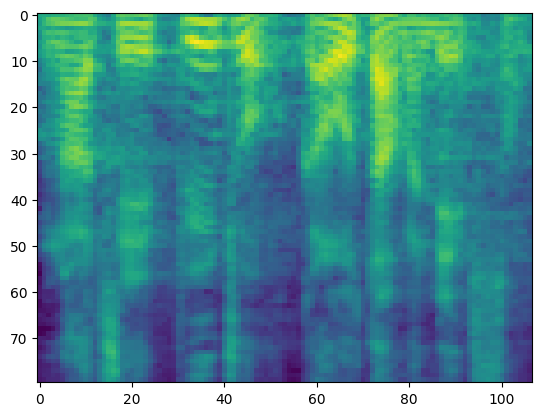

In [71]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"][0].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [72]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [73]:
i = 3
text = converter.toUnicode(tokenizer.decode(processed_example["input_ids"][i]).replace("</s>", "").replace("<unk>", ""))
print(text)
spectrogram = torch.tensor(processed_example["labels"][i])
with torch.no_grad():
    speech = vocoder(spectrogram)
display_audio(speech.cpu().numpy(), rate=16000)

ཁྱིམ་མཚེས་ཚང་མས་འཛུམ་མུལ་མུལ་གྱིས་འཚམས་འདྲི་ཞུ་ཞིང་།


In [74]:
dataset["train"][0]["uni"]

'ང་ཚོའི་སྤུན་གྲོགས་གོ་ཏ་མ་སླེབས་སོང་།'

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

In [75]:
dataset['train'] = dataset['train'].map(
    prepare_dataset, 
    remove_columns=dataset['train'].column_names, 
    batched=True,
    batch_size=32
)

dataset['test'] = dataset['test'].map(
    prepare_dataset, 
    remove_columns=dataset['test'].column_names, 
    batched=True,
    batch_size=32
)

Map:   0%|          | 0/119949 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
import random
i = random.choice(range(len(dataset["train"])))
text = converter.toUnicode(tokenizer.decode(dataset["train"][i]["input_ids"]).replace("</s>", "").replace("<unk>", ""))
print(text)
spectrogram = torch.tensor(dataset["train"][i]["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)
display_audio(speech.cpu().numpy(), rate=16000)

How many examples are left?

In [163]:
len(dataset['train'])

95

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [164]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [165]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [166]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [167]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 241]),
 'attention_mask': torch.Size([3, 241]),
 'labels': torch.Size([3, 762, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [169]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [170]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./TTS_st5_test",  # change to a repo name of your choice
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    num_train_epochs=1,
    learning_rate=1e-5,
    warmup_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=50,
    save_total_limit=20,
    report_to=["wandb"],
    label_names=["labels"],
)

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [171]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)
torch.cuda.empty_cache()

/tmp/ipykernel_129902/54815936.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [172]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tashitsering (TMLM). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss


/opt/conda/lib/python3.11/site-packages/transformers/modeling_utils.py:2816: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=3, training_loss=0.9319492975870768, metrics={'train_runtime': 6.0298, 'train_samples_per_second': 15.755, 'train_steps_per_second': 0.498, 'total_flos': 20688386804712.0, 'train_loss': 0.9319492975870768, 'epoch': 1.0})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "VoxPopuli",  # a 'pretty' name for the training dataset
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "SpeechT5 TTS Dutch",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

You can now share this model with anyone using the link on the Hub.

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [48]:
model = SpeechT5ForTextToSpeech.from_pretrained("TTS_st5/checkpoint-60000")

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [49]:
model.push_to_hub('TTS_AB-all_run2')

pytorch_model.bin:   0%|          | 0.00/578M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spsitherMonlamAI/TTS_AB-all_run2/commit/ef311f60f14f98ce4fde289d924184107c21fc91', commit_message='Upload SpeechT5ForTextToSpeech', commit_description='', oid='ef311f60f14f98ce4fde289d924184107c21fc91', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
example = dataset["test"][1008]#457 female
speaker_embeddings = torch.tensor(create_speaker_embedding(example["path"]["array"])).unsqueeze(0)
speaker_embeddings.shape
from IPython.display import Audio

Audio(example["path"]["array"], rate=16000)


Define some input text and tokenize it.

In [576]:
example = dataset["test"][28]
text = example['sentence']
from IPython.display import Audio


print(text)
Audio(example["path"]["array"], rate=16000)

tshogs kyis ring por mi thogs par/


In [562]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [577]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [578]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

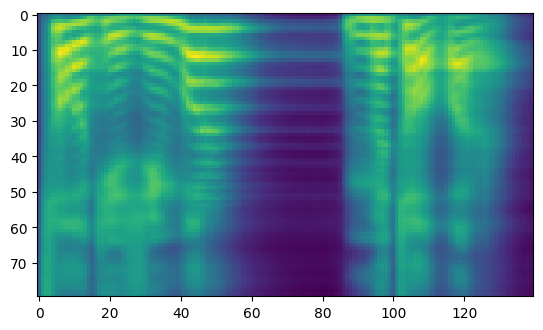

In [579]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [580]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [581]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [448]:
import soundfile as sf
sf.write("../output.wav", speech.numpy(), samplerate=16000)

## Building a demo

To showcase your newly fine-tuned model, make a demo on Hugging Face Spaces! We've created a [template Gradio demo](https://huggingface.co/spaces/Matthijs/speecht5-tts-demo) that you can easily copy and make your own.

Click the link to duplicate the template demo to your account: https://huggingface.co/spaces/Matthijs/speecht5-tts-demo?duplicate=true (or from the three-dot button at the top choose **Duplicate this Space**).

We recommend giving your space a similar name to your fine-tuned model (e.g. `speecht5_tts_voxpopuli_nl`) and setting the visibility to "Public".

Once you've duplicated the Space to your account, click **Files and versions > app.py > edit**. Change the model identifier to your fine-tuned model (line 9). Scroll to the bottom of the page and click **Commit changes to main**. The demo will reboot, this time using your fine-tuned model.

You can share this demo with your friends and family so that they can use the model that you've trained!

## Conclusion

That's it, you've fine-tuned SpeechT5 for TTS on a custom dataset!

In our experience, it can be difficult to get good results out of this model. The results can be rather noisy and sometimes what the model outputs doesn't even sound like speech at all. A lot of this appears to be related to the speaker embeddings. Since SpeechT5 was pre-trained with English x-vectors, it gives the best results using those English speaker embeddings. So if the generated speech sounds bad, try using a different speaker embedding and it might improve.

Of course, the demo above was only trained for 3000 iterations. Training for longer should improve the results. Even so, the speech clearly is Dutch instead of English, and it does capture the voice characteristics of the speaker (compare to the original audio in the example).

Another thing to experiment with is the model's configuration. For example, try using `config.reduction_factor = 1` to see if this improves the results.

A final note on ethical concerns: While TTS technology has many beneficial uses, it can also be used for nefarious purposes such as imitating someone's voice without their permission. Please use TTS wisely and responsibly!